# Instalação de Pacotes

In [ ]:
!pip install -r requirements.txt

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached debugpy-1.8.6-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached deepchem-2.5.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached executing-2.1.0-py2.py3-none-any.whl.metadata (8.9 kB)
  Using cached grpcio-1.66.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached ipykernel-6.29.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached ipython-8.28.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached jupyt

In [ ]:
!pip show lime

# Carregamento Pacotes


In [ ]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Executando em: {device}")

2.5.0+cu121
Executando em: cpu


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# Carregamento do Conjunto de Dados (QM9)

## Dropbox link (Download)

In [ ]:
import os
import zipfile
import requests

# URL do arquivo no Dropbox com `?dl=1` para forçar o download direto
url = "https://www.dropbox.com/scl/fi/lbs52lc0av3eqi9zws3wp/QM9.zip?rlkey=925vtuebvf7kf9ifq9143d6az&dl=1"
zip_path = "QM9.zip"
qm9_folder = "QM9Data"

# Baixar o arquivo se ele não existir localmente
if not os.path.exists(zip_path):
    print("Baixando o arquivo QM9.zip...")
    response = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download concluído.")

# Criar a pasta de extração, se necessário
if not os.path.exists(qm9_folder):
    os.makedirs(qm9_folder)

# Extrair o conteúdo do arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(qm9_folder)

print(f"Dados salvos em: {qm9_folder}")


Dados salvos em: QM9Data


# Extração e Preparação dos Dados


In [ ]:
with open(qm9_folder+"/dsgdb9nsd_075700.xyz") as file:
    for line in file:
        print(line)

16

gdb 75700	2.29421	2.10153	1.19281	1.5927	71.76	-0.2569	-0.021	0.2359	1002.3496	0.125963	-434.09168	-434.083979	-434.083035	-434.123886	28.894	

C	 0.0082723652	 1.4385040241	 0.0216304465	-0.368015

N	-0.0080626856	-0.0080486441	-0.0143324088	-0.128223

C	-0.0025221437	-0.7715337629	-1.1909538518	 0.388126

N	 0.0263387403	-0.3906951642	-2.3959782595	-0.532716

N	-0.0435539427	-2.1606959554	-0.8372214133	-0.113662

C	 1.1983737221	-2.6000297832	-0.1756188576	-0.242408

C	 0.0113061798	-2.2080435108	 0.6349537932	-0.162296

C	-0.0270216144	-0.7926214222	 1.1346516211	 0.42506

O	-0.0955434019	-0.3870203764	 2.2694066024	-0.371241

H	 0.9216696532	 1.8340504971	-0.4354195835	 0.141444

H	-0.8595819793	 1.8482562075	-0.5050019382	 0.146272

H	-0.0319704226	 1.7357251605	 1.0706204257	 0.173704

H	 0.0660884133	 0.6248858104	-2.4690959743	 0.222945

H	 1.4244948343	-3.6539669067	-0.2978095694	 0.14517

H	 2.0547706395	-1.9318987311	-0.1997156332	 0.140887

H	-0.5885282877	-2.9489560327

In [ ]:
def load_qm9_xyz(file_path):
    """Load a single QM9.xyz file."""
    with open(file_path, 'r') as f:
        # Number of atoms
        natoms = int(f.readline())
        # Properties are in the second line
        properties = list(map(float, f.readline().split()[2:]))
        # Read atomic coordinates and types
        atoms = []
        coordinates = []
        # print(properties)
        for num_line, line in enumerate(f):
            # print(num_line, line)
            if num_line >= 0 and num_line < natoms:
                info = line.replace("*^","e").split()
                atoms.append(info[0])
                coordinates.append(list(map(float, info[1:-1])))

    return {
        "natoms": natoms,
        "atoms": atoms,
        "coordinates": np.array(coordinates),
        "properties": properties
    }

def load_qm9_dataset(directory_path, list_mols=[]):
    """Load the entire QM9 dataset from a directory containing .xyz files."""
    X = []
    Y = []
    S = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xyz"):
            file_path = os.path.join(directory_path, file_name)
            molecule_data = load_qm9_xyz(file_path)
            if molecule_data['natoms'] in list_mols or len(list_mols)==0:
              X.append([molecule_data['atoms'], molecule_data['coordinates']])
              Y.append(molecule_data['properties'])
              S.append(molecule_data['natoms'])
    return X, Y, S

In [ ]:
# Loading
# segundo parâmetro: lista com o tamanho das moléculas desejadas | [] para selecionar todas]
XYZ, Y, natoms = load_qm9_dataset(qm9_folder)
Y = np.array(Y)

samples =  len(XYZ)
print(f"Numero Moléculas: {samples}")
print(f"Primeira Molécula: {XYZ[0]}")
print(f"Propriedades Mol[0]: {Y[0]}")


Numero Moléculas: 133885
Primeira Molécula: [['O', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'], array([[ 0.02357102,  0.92573576,  1.58429548],
       [-0.02585037,  1.4160204 ,  0.47549997],
       [-1.37654544,  1.86495537, -0.08391578],
       [-1.43539921,  2.01547325, -1.47904061],
       [-0.91772959,  3.22378564, -1.97349621],
       [ 0.60376273,  3.28073209, -2.11732547],
       [ 1.09977905,  4.11315065, -2.84759721],
       [ 1.48628276,  2.33617496, -1.38128172],
       [ 1.22673904,  1.56748784, -0.31245123],
       [-2.10286898,  1.09701515,  0.19586179],
       [-1.66530212,  2.7938882 ,  0.43591959],
       [-1.33327147,  3.37596609, -2.97335656],
       [-1.23063074,  4.08149739, -1.35466783],
       [ 2.5047307 ,  2.37056364, -1.76048904],
       [ 2.04452154,  1.00756912,  0.1346948 ]])]
Propriedades Mol[0]: [ 3.14044000e+00  1.31863000e+00  9.79600000e-01  5.88700000e-01
  7.08500000e+01 -2.53700000e-01 -1.01500000e-01  1.52200000e-01
  1.1

In [ ]:
natoms = np.array(natoms)
min_atoms = np.min(natoms)
max_atoms = np.max(natoms)
print(f"Menor Molécula: {min_atoms}")
print(f"Maior Molécula: {max_atoms}")

Menor Molécula: 3
Maior Molécula: 29


# Geração dos Descritores (DScribe)

- Matriz de Coulomb (CM)
- Atom-centered Symmetry Functions (ACSF)
- Smooth Overlap of Atomic Positions (SOAP)
- Many-body Tensor Representation (MBTR)


In [ ]:
from ase import Atoms

In [ ]:
from dscribe.descriptors import CoulombMatrix, ACSF, SOAP, MBTR

mols = [Atoms(positions=coordinates, symbols=symbols) for (symbols, coordinates) in XYZ]

# informa o tipo de descritor selecionado
descriptor = 'CM' # CM, SOAP, MBTR, ACSF

## Matriz de Coulomb (CM)

In [ ]:
if descriptor == 'CM':
    cm = CoulombMatrix(n_atoms_max=max_atoms, permutation="eigenspectrum")
    X = cm.create(mols)
    print(X.shape)

(133885, 29)


## Atom-centered Symmetry Functions (ACSF)

---



In [ ]:
if descriptor == 'ACSF':
    acsf = ACSF(
        species=["H", "C", "O", "N", "F"],
        r_cut=6.0,
        g2_params=[[1, 1], [1, 2], [1, 3]],
        g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
    )
    centers = samples*[[0]]
    X = acsf.create(mols, centers).reshape([samples,-1])
    print(X.shape)

## Smooth Overlap of Atomic Positions (SOAP)

In [ ]:
if descriptor == 'SOAP':
    soap = SOAP(
        species=["H", "C", "O", "N", "F"],
        periodic=False,
        r_cut=6.0,
        n_max=8,
        l_max=6,
    )

    centers = samples*[[0]]
    X = soap.create(mols, centers).reshape([samples, -1])
    print(X.shape)

## Many-body Tensor Representation (MBTR)

In [ ]:
if descriptor == 'MBTR':
  mbtr = MBTR(
      species=["H", "C", "O", "N", "F"],
      geometry={"function": "distance"},
      grid={"min": 0.4, "max": 8, "sigma": 0.1, "n": 100},
      periodic=False,
      sparse=False,
      normalization="l2",
  )

  X = mbtr.create(mols)
  print(X.shape)

# Preparação dos Dados


In [ ]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

**Q9 Dataset: Propriedades**

0. Rotational constant A: GHz
1. Rotational constant B: GHz
2. Rotational constant C: GHz
3. Dipole moment (μ): Debye (D)
4. Isotropic polarizability (α): atomic units (a.u.)
5. Energy of HOMO (ϵHOMO): Hartree (Ha)
6. Energy of LUMO (ϵLUMO): Hartree (Ha)
7. Gap (ϵgap): Hartree (Ha)
8. Electronic spatial extent: atomic units (a.u.)
9. Zero point vibrational energy (zpve): Hartree (Ha)
10. Internal energy at 0 K (U0): Hartree (Ha)
11. Internal energy at 298.15 K (U): Hartree (Ha)
12. Enthalpy at 298.15 K (H): Hartree (Ha)
13. Free energy at 298.15 K (G): Hartree (Ha)
15. Heat capacity at 298.15 K (Cv): cal/mol·K



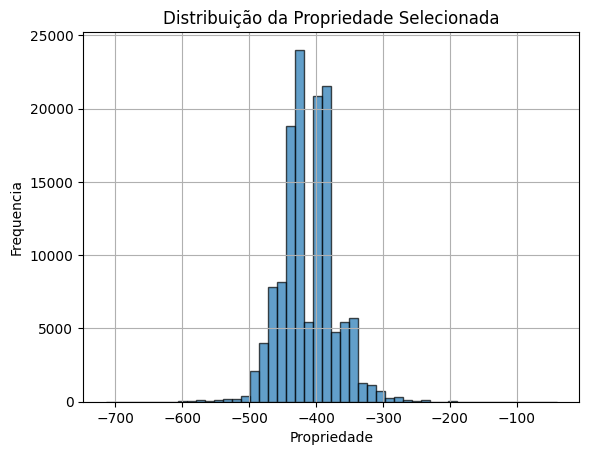

In [ ]:
# Seleção da propriedade alvo
att_alvo = 10 # 15 propriedades [0-14]
Ys = Y[:,att_alvo].reshape(-1,1)
plt.hist(Y[:,att_alvo], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Propriedade')
plt.ylabel('Frequencia')
plt.title('Distribuição da Propriedade Selecionada')
plt.grid(True)
plt.show()


In [ ]:
# Normalização, Split, DataLoader
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xn = scaler.fit_transform(X)

In [ ]:
class Data(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).float(), torch.from_numpy(self.targets[idx]).float()

dataset = Data(Xn,Ys)

In [ ]:
batch_size = 256

train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Rede Neural


## Modelo (Pytorch)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, layers, lr=0.001):
        super(MLP, self).__init__()
        all_layers = []
        prev_dim = input_dim

        # Camadas ocultas
        for layer_dim in layers:
            all_layers.append(nn.Linear(prev_dim, layer_dim))
            all_layers.append(nn.ReLU())
            prev_dim = layer_dim

        # Camada de saída (ativação linear - regressão)
        all_layers.append(nn.Linear(prev_dim, output_dim))

        # Combinando as camadas
        self.layers = nn.Sequential(*all_layers)

        self.criterion = nn.L1Loss() #nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        return self.layers(x)

    def train_model(self, dataloader):
        self.train()
        total_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self(batch_x)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def validate_model(self, dataloader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self(batch_x)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def test_model(self, dataloader):
        self.eval()
        predictions = []
        targets = []
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self(batch_x)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
                predictions.extend(outputs.cpu().tolist())
                targets.extend(batch_y.cpu().tolist())
        return predictions, targets, total_loss / len(dataloader)

    def predict(self, dataloader):
        self.eval()
        predictions = []
        with torch.no_grad():
            for batch_x, _ in dataloader:
                batch_x = batch_x.to(device)
                outputs = self(batch_x)
                predictions.extend(outputs.cpu().tolist())
        return predictions

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


## Otimizando os Hiperparâmetros

### Função Objetivo Optuna

In [ ]:
def objective(trial):
    early_stopping = EarlyStopping(patience=7, verbose=False)
    # lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    lr = 0.001
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i+1}', 20, 400, 20))

    model = MLP(input_dim=X.shape[1], output_dim=1, layers=layers, lr=lr).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(2000): # máximo épocas
        train_loss = model.train_model(train_loader)
        val_loss = model.validate_model(val_loader)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            break
    return val_loss


### Otimização

**Cuidado:** O custo computacional pode ser elevado

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Número de tentativas: ', len(study.trials))
print('Melhor Resultado:')
trial = study.best_trial

print('MAE: ', trial.value)
print('Hiperparâmetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-11-08 15:53:57,477] A new study created in memory with name: no-name-69017d03-d630-445a-b0ec-61069c1bc29f
<ipython-input-77-1ab0a2b2131c>:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  layers.append(trial.suggest_int(f'n_units_l{i+1}', 20, 400, 20))
[I 2024-11-08 15:56:39,989] Trial 0 finished with value: 1.187651479019309 and parameters: {'n_layers': 3, 'n_units_l1': 80, 'n_units_l2': 120, 'n_units_l3': 260}. Best is trial 0 with value: 1.187651479019309.
[I 2024-11-08 16:00:50,362] Trial 1 finished with value: 0.9806900361798844 and parameters: {'n_layers': 3, 'n_units_l1': 240, 'n_units_l2': 240, 'n_units_l3': 100}. Best is trial 1 with value: 0.9806900361798844.
[I 2024-11-08 16:03:04,663] Trial 2 finished with value: 0.3338164282294939 and parameters: {'n_layers': 2, 'n_units_l1': 120, 'n_units_l2': 20}. Best is trial 2 with value: 0.3338164282294939.
[I 2024-11-08 16:05:20,832] Trial 3 finish

Número de tentativas:  10
Melhor Resultado:
MAE:  0.17417147952430653
Hiperparâmetros: 
    n_layers: 1
    n_units_l1: 100


## Treinamento

Época 10/1000, Train Loss: 6.1888, Validation Loss: 5.1392
Época 20/1000, Train Loss: 0.3586, Validation Loss: 0.3761
Época 30/1000, Train Loss: 0.1971, Validation Loss: 0.2137
Época 40/1000, Train Loss: 0.1654, Validation Loss: 0.1568
Época 50/1000, Train Loss: 0.1549, Validation Loss: 0.1757
Época 60/1000, Train Loss: 0.1573, Validation Loss: 0.1798
Época 70/1000, Train Loss: 0.1554, Validation Loss: 0.1656
Época 80/1000, Train Loss: 0.1566, Validation Loss: 0.1382
Época 90/1000, Train Loss: 0.1538, Validation Loss: 0.1433
Early stopping


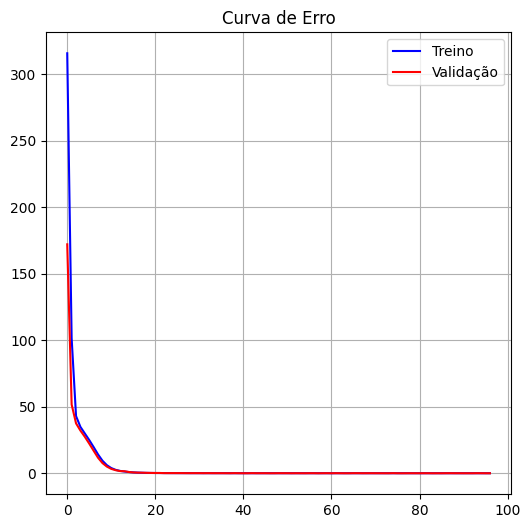

In [ ]:
num_epochs = 1000
learning_rate = 0.001
# Definição do Modelo
model = MLP(input_dim=X.shape[1], output_dim=1, layers=[180], lr=learning_rate).to(device)

# Early Stop
early_stopping = EarlyStopping(patience=20, verbose=False)

tloss = []
vloss = []
for epoch in range(num_epochs):
    train_loss = model.train_model(train_loader)
    val_loss = model.validate_model(val_loader)
    tloss.append(train_loss)
    vloss.append(val_loss)
    if (epoch+1) % 10 == 0:
        print(f"Época {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Curva de Erro")
ax.plot(tloss,'blue', label='Treino')
ax.plot(vloss,'red', label='Validação')
ax.legend()
ax.grid(True)
plt.show()


Erro de predição (MAE) no conjunto de teste: 0.12507572770118713


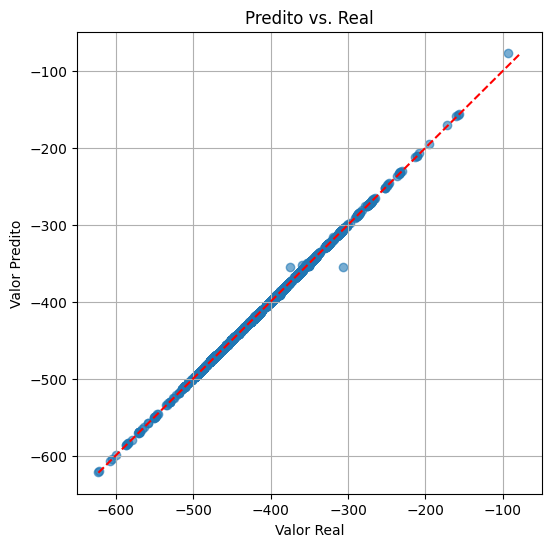

In [ ]:
Yp, Yt, loss_test = model.test_model(test_loader)

plt.figure(figsize=(6, 6))
plt.scatter(Yp, Yt, alpha=0.6)

max_val = max(max(Yt), max(Yp))
min_val = min(min(Yt), min(Yp))
plt.plot([min_val, max_val], [min_val, max_val], 'r', linestyle='--')

plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title('Predito vs. Real')
plt.grid(True)

print(f"Erro de predição (MAE) no conjunto de teste: {loss_test}")

plt.show()



In [126]:
import importlib
import chemXAI  # Importa o módulo inicialmente

# ... faça algumas modificações no arquivo do seu_modulo ...

importlib.reload(chemXAI)  # Recarrega o módulo com as modificações

<module 'chemXAI' from '/content/chemXAI.py'>

# Explicação com Shap

In [111]:
from chemXAI import Shap

In [112]:
# Inicializa a classe Shap com o modelo e DataLoaders
shap_explainer = Shap(model, train_loader, test_loader, device)

# Gera e exibe uma explicação local para a primeira instância no batch de teste
local_explanation = shap_explainer.local_explanation(0)

# Gera e exibe a explicação global
global_explanation = shap_explainer.global_explanation()

Background shape: (256, 29)
Test data shape: (256, 29)


  0%|          | 0/256 [00:00<?, ?it/s]

Local SHAP values shape: (29,)
Global SHAP values shape: (29,)


In [113]:
print(local_explanation)

    Feature Index  SHAP Value
0              11    0.076665
1              13    0.043402
2              12    0.040609
3              14    0.030483
4              10    0.028477
5              15    0.026699
6              16    0.020237
7               9    0.013731
8              21    0.007556
9              26    0.005956
10             27    0.000000
11             25    0.000000
12             24    0.000000
13             22    0.000000
14             28    0.000000
15             23   -0.007080
16             20   -0.016445
17             19   -0.020952
18             18   -0.032446
19             17   -0.121064
20              6   -0.850976
21              7   -1.093824
22              8   -1.739369
23              5   -2.473748
24              0   -4.400051
25              4   -6.044655
26              2  -10.742649
27              3  -12.071439
28              1  -28.967463


In [114]:
print(global_explanation)

    Feature Index  Importance
0               0   11.881087
1               1    7.627872
2               2    7.216624
3               3    5.151014
4               4    3.267092
5               5    2.615938
6               6    2.146208
7               8    1.933986
8               7    1.727913
9              12    0.194102
10             13    0.180238
11             11    0.123870
12             10    0.100744
13             14    0.081444
14             15    0.055903
15             16    0.054700
16             18    0.048462
17             19    0.038560
18             17    0.038325
19             20    0.035977
20              9    0.033281
21             23    0.018472
22             21    0.017547
23             22    0.008453
24             24    0.004262
25             25    0.003941
26             26    0.003915
27             27    0.000000
28             28    0.000000


# Explicação com LIME

In [128]:
from chemXAI import LIME

In [136]:
# Instancia a explicação
lime_explainer = LIME(model, train_loader, test_loader, device, mode='regression')

# Gera e exibe uma explicação local para a primeira instância no batch de teste
local_explanation = lime_explainer.local_explanation(0)

Intercept -391.7303488780705
Prediction_local [-469.58754551]
Right: -476.4426


In [137]:
local_explanation

,Feature,LIME Value
10,-0.80 < Feature 13 <= -0.13,1.127341
12,-0.23 < Feature 10 <= 0.21,0.948692
13,Feature 15 <= -0.39,0.732706
14,Feature 20 <= 0.11,0.715445
19,Feature 19 <= 0.22,0.381331
27,Feature 27 <= 0.01,0.000000
26,Feature 26 <= 0.00,0.000000
25,Feature 25 <= 0.01,0.000000
24,Feature 23 <= 0.07,0.000000
28,Feature 28 <= 0.00,0.000000


# Experimentos (Sugestões)






1. Verificar o modelo para os outros descritores
2. Verificar por que os valores de shapley e os valores do LIME mostram diferentes tipos de explicação
